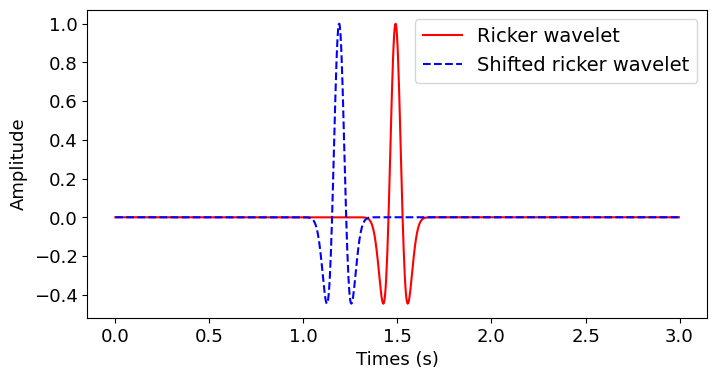

In [68]:
import numpy as np
import matplotlib.pyplot as plt
from ADFWI.view        import *
from ADFWI.utils       import *

# source wavelet
def wavelet(nt, dt, f0, amp0 = 1, t0 = None, type = 'Ricker'):
    """ source time function.
    """
    # time array
    t = np.arange(nt) * dt + 0.0
    wavelet = np.zeros_like(t)
    t0 = t0 if t0 is not None else 1.2 / f0

    # Ricker wavelet
    if type.lower() in ['ricker']:
        tau = (np.pi*f0) ** 2
        wavelet = amp0 * (1 - 2 * tau * (t - t0) ** 2) * np.exp(- tau * (t - t0) ** 2)
    
    # Gaussian wavelet
    elif type.lower() in ['gaussian']:
        tau = (np.pi*f0) ** 2
        wavelet = amp0 * (1 - 2 * tau * (t - t0) ** 2) * np.exp(- tau * (t - t0) ** 2)

        # perform integration twice to get the Gaussian wavelet
        wavelet = np.cumsum(wavelet)
        wavelet = np.cumsum(wavelet)

    # Ramp wavelet
    elif type.lower() in ['ramp']:
        wavelet = amp0 * 0.5 * (1. + np.tanh(t / t0))
        
    # Unknown source type
    else:
        msg = 'Support source types: Rikcer, Guassian, Ramp. \n'
        err = 'Unknown source type: {}'.format(type)
        raise ValueError(msg + '\n' + err)

    return t,wavelet

nt = 1000
dt = 0.003
f0 = 6
tlist,ricker = wavelet(nt,dt,f0,amp0=1,t0=0.5)
ricker       = np.roll(ricker,330)
shift_ricker = np.roll(ricker,-100)

plt.figure(figsize=(8,4))
plt.plot(tlist,ricker       ,c='r',linestyle="-"    ,label="Ricker wavelet")
plt.plot(tlist,shift_ricker ,c='b',linestyle="--"   ,label="Shifted ricker wavelet")
plt.legend(fontsize=14)
plt.xlabel("Times (s)",fontsize=13)
plt.ylabel("Amplitude",fontsize=13)
plt.tick_params(labelsize=13)
plt.show()

In [69]:
import numpy as np
from scipy.signal import stft, get_window

def gabor_transform(signal, fs, nperseg):
    """
    Perform Gabor transform for time-frequency analysis.
    
    Parameters:
    signal -- Input raw waveform data.
    fs -- Sampling frequency.
    nperseg -- Length of each segment.
    
    Returns:
    Time-frequency representation after transformation.
    """
    std_dev = nperseg / 6  # Example standard deviation for the Gaussian window
    window = get_window(('gaussian', std_dev), nperseg)
    frequencies, times, Zxx = stft(signal, fs=fs, window=window, nperseg=nperseg)
    return Zxx

def calculate_sigma_cor_p(signal_d, signal_u, fs, nperseg):
    """
    Calculate σcor−p(v), including Gabor transform.
    
    Parameters:
    signal_d -- Raw waveform of observed data.
    signal_u -- Raw waveform of synthetic data.
    fs -- Sampling frequency.
    nperseg -- Length of each segment.
    
    Returns:
    Result of σcor−p(v) calculation.
    """
    # Perform Gabor transform
    d_gabor = gabor_transform(signal_d, fs, nperseg)
    u_gabor = gabor_transform(signal_u, fs, nperseg)

    # Extract amplitude and phase
    d_amplitude = np.abs(d_gabor)
    d_phase     = np.angle(d_gabor)
    u_amplitude = np.abs(u_gabor)
    u_phase     = np.angle(u_gabor)

    # Calculate complex forms
    d_new = np.exp(1j * d_phase)
    u_new = np.exp(1j * u_phase)

    # Calculate W as the product of the real parts of d and u
    # W = np.abs(d_amplitude) * np.abs(u_amplitude)
    W = d_amplitude * u_amplitude

    # Calculate σcor−p(v) using vectorized operations
    sigma_cor_p = -np.sum(W * np.real(np.conj(u_new) * d_new))

    return sigma_cor_p

# Call the function
fs      = int(1/dt)
nperseg = 50
result  = calculate_sigma_cor_p(ricker, ricker, fs, nperseg)

# Output the result
print("σcor−p(v):", result)

σcor−p(v): -0.8916691627450228


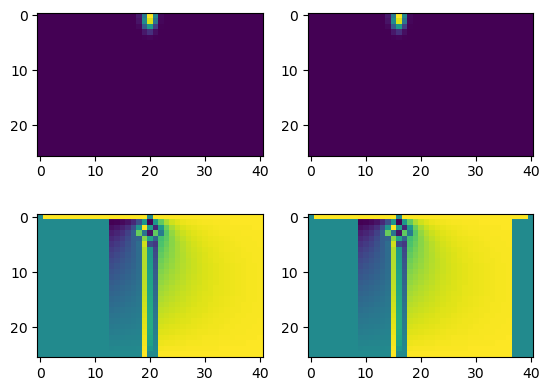

In [70]:
fs      = int(1/dt)
nperseg = 50

d_gabor = gabor_transform(ricker, fs, nperseg)
u_gabor = gabor_transform(shift_ricker, fs, nperseg)
# Extract amplitude and phase
d_amplitude = np.abs(d_gabor)
d_phase = np.angle(d_gabor)
u_amplitude = np.abs(u_gabor)
u_phase = np.angle(u_gabor)

fig,axs = plt.subplots(2,2)
axs[0][0].imshow(d_amplitude)
axs[0][1].imshow(u_amplitude)

axs[1][0].imshow(d_phase)
axs[1][1].imshow(u_phase)
plt.show()

In [98]:
import torch
from scipy.signal import get_window

def torch_stft(signal, fs=1.0, nperseg=256, noverlap=None, nfft=None, window=None):
    """
    Perform Short-Time Fourier Transform (STFT) using PyTorch, emulating SciPy's stft.
    
    Parameters:
    signal -- Input raw waveform data (Torch tensor).
    fs -- Sampling frequency (float, default: 1.0).
    nperseg -- Length of each segment (int, default: 256).
    noverlap -- Number of points to overlap between segments (int, default: nperseg // 2).
    nfft -- Number of FFT points (default: nperseg).
    window -- Pre-computed windowing function (Torch tensor).
    
    Returns:
    frequencies -- Frequency bins (1D tensor).
    times -- Time bins (1D tensor).
    Zxx -- Time-frequency representation (2D complex tensor), containing only positive frequencies.
    """
    if noverlap is None:
        noverlap = nperseg // 2  # Default overlap of 50%
    
    if nfft is None:
        nfft = nperseg  # Default FFT length is equal to the window size

    # If no window is provided, use a Hann window
    if window is None:
        window_np = get_window('hann', nperseg)
        window = torch.tensor(window_np, dtype=torch.float32, device=signal.device)

    # Calculate hop length
    hop_length = nperseg - noverlap

    # Pad the signal if necessary
    pad_len = nperseg - (signal.size(0) % hop_length)
    padded_signal = torch.cat((signal, torch.zeros(pad_len, device=signal.device)))

    # Number of frames
    num_frames = (padded_signal.size(0) - nperseg) // hop_length + 1

    # Initialize STFT result
    stft_result = torch.zeros((num_frames, nfft), dtype=torch.complex64, device=signal.device)

    # Compute STFT frame by frame
    for i in range(num_frames):
        start = i * hop_length
        segment = padded_signal[start:start + nperseg]
        segment_windowed = segment * window  # Apply window function
        stft_result[i] = torch.fft.fft(segment_windowed, n=nfft)  # FFT with nfft points

    # Keep only the positive frequencies (mimic scipy behavior)
    stft_result = stft_result[:, :nfft // 2 + 1]

    # Calculate frequencies and times (mimic scipy behavior)
    frequencies = torch.fft.rfftfreq(nfft, d=1/fs).to(signal.device)
    times = torch.arange(num_frames, device=signal.device) * hop_length / fs

    return frequencies, times, stft_result.T  # Transpose to match SciPy's output format

def gabor_transform_torch(signal, fs, nperseg):
    """
    Perform Gabor transform for time-frequency analysis using PyTorch.
    
    Parameters:
    signal -- Input raw waveform data (Torch tensor).
    fs -- Sampling frequency (float).
    nperseg -- Length of each segment (int).
    
    Returns:
    Zxx -- Time-frequency representation (Torch tensor).
    """
    std_dev = nperseg / 6  # Standard deviation for the Gaussian window
    window_np = get_window(('gaussian', std_dev), nperseg)
    window = torch.tensor(window_np, dtype=torch.float32, device=signal.device)

    frequencies, times, Zxx = torch_stft(signal, fs=fs, window=window, nperseg=nperseg)
    return Zxx

def calculate_sigma_cor_p(signal_d, signal_u, fs, nperseg):
    """
    Calculate σcor−p(v), including Gabor transform using PyTorch.
    
    Parameters:
    signal_d -- Raw waveform of observed data (Torch tensor).
    signal_u -- Raw waveform of synthetic data (Torch tensor).
    fs -- Sampling frequency.
    nperseg -- Length of each segment.
    
    Returns:
    Result of σcor−p(v) calculation (Torch tensor).
    """
    # Perform Gabor transform
    d_gabor = gabor_transform_torch(signal_d, fs, nperseg)
    u_gabor = gabor_transform_torch(signal_u, fs, nperseg)
    
    # Extract amplitude and phase
    d_amplitude = torch.abs(d_gabor)
    d_phase = torch.angle(d_gabor)
    u_amplitude = torch.abs(u_gabor)
    u_phase = torch.angle(u_gabor)

    # Calculate W as the product of the amplitudes
    W = d_amplitude * u_amplitude

    # Calculate complex forms
    d_new = torch.exp(1j * d_phase)
    u_new = torch.exp(1j * u_phase)

    # Calculate σcor−p(v) using vectorized operations
    sigma_cor_p = -torch.sum(W * torch.real(torch.conj(u_new) * d_new))

    return sigma_cor_p

# Call the function
fs      = int(1/dt)
nperseg = 128
ricker_tensor = numpy2tensor(ricker)
result  = calculate_sigma_cor_p(ricker_tensor, ricker_tensor, fs, nperseg)

# Output the result
print("σcor−p(v):", result)

σcor−p(v): tensor(-644.8024)


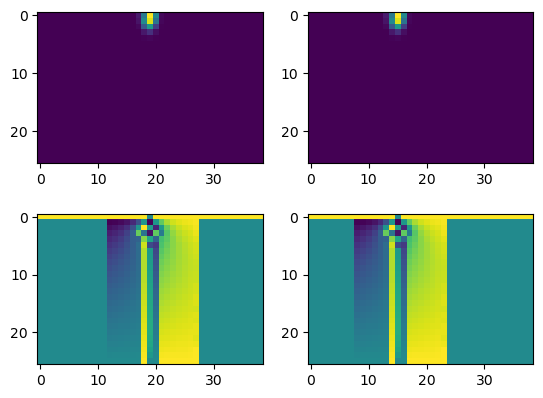

In [95]:
fs      = int(1/dt)
nperseg = 50

ricker_tensor = numpy2tensor(ricker)
ricker_shift_tensor = numpy2tensor(shift_ricker)
d_gabor = gabor_transform_torch(ricker_tensor, fs, nperseg)
u_gabor = gabor_transform_torch(ricker_shift_tensor, fs, nperseg)
# Extract amplitude and phase
d_amplitude = np.abs(d_gabor)
d_phase = np.angle(d_gabor)
u_amplitude = np.abs(u_gabor)
u_phase = np.angle(u_gabor)

fig,axs = plt.subplots(2,2)
axs[0][0].imshow(d_amplitude)
axs[0][1].imshow(u_amplitude)

axs[1][0].imshow(d_phase)
axs[1][1].imshow(u_phase)
plt.show()

In [96]:
d_gabor_torch   = gabor_transform_torch(ricker_tensor, fs, nperseg)
d_gabor         = gabor_transform(ricker, fs, nperseg)

d_gabor_torch.real.numpy(),d_gabor.real

(array([[-0., -0., -0., ..., -0., -0., -0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 array([[ 0.00000000e+000, -0.00000000e+000, -0.00000000e+000, ...,
         -1.10093122e-255, -2.97791710e-286, -1.47394604e-318],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         -1.09988403e-255, -2.97559924e-286, -1.47300238e-318],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         -1.09677994e-255, -2.96872074e-286, -1.47019608e-318],
        ...,
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         -9.17381173e-256, -2.54978215e-286, -1.29151724e-318],
        [ 0.00000000e+000,  0.00000000e+000,  0.00000000e+000, ...,
         -9.15852952e-256, -2.54602011e-286, -1.28984236e-318],
        [ 0.00000000e+000, 

ValueError: operands could not be broadcast together with shapes (26,41) (26,39) 

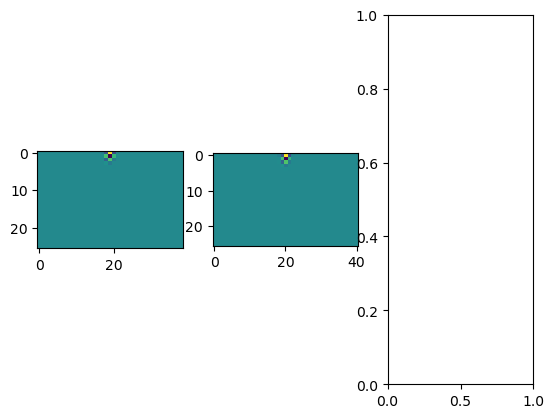

In [97]:
plt.figure()
plt.subplot(131)
plt.imshow(d_gabor_torch.real.numpy())
plt.subplot(132)
plt.imshow(d_gabor.real)
plt.subplot(133)
plt.imshow(np.abs(d_gabor.real/d_gabor.real - d_gabor_torch.real.numpy()))
plt.show()
np.abs(d_gabor.real - d_gabor_torch.real.numpy()).mean()